In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt 

from cirq import Circuit
from cirq.devices import GridQubit
from cirq.google import XmonSimulator

# Quantum Compression


## Introduction
Goal: Simulate an Ising chain of n-qubits, using only log(n) qubits. Specifically, the paper does a four qubit Ising chain using two qubits. We must decompose the circuits for compressed simulation into the available gate set. We must also run the experiment often enough so that statistical errors are reduced. Systematic errors must be estimated using independent controlled circuits of  similar complexity to the one of interest. Since we are running in simulation via Cirq, this may be less of an issue.

We use the following set up in Cirq for the rest of the tutorial.

In [2]:
qubits = cirq.LineQubit.range(3)
qubit0, qubit1, qubit2 = qubits

circuit = cirq.Circuit()

## Step 1
Prepare the input state $\rho_{i n} = \frac{1}{2^{m-1}} I^{\otimes m-1} \otimes |+_{y} \rangle \langle+_{y} |$ where $Y |+_{y} \rangle=|+_{y} \rangle$ by applying $S^{\dagger}H$ on qubit $0$, $H$ on an auxilirary qubit $2$, and $CNOT$ on qubits $1$ and $2$ with qubit $1$ being the target and qubit $2$ the control.

In [3]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.S(qubit0)**-1])
circuit.append([cirq.H(qubit2)])
circuit.append([cirq.CNOT(control=qubit2, target=qubit1)])

circuit

0: ───H───S^-1───────────

1: ──────────────────X───
                     │
2: ──────────────H───@───

## Step 2

Evolve the system up to the desired value of $J$, which in this case is $J = 1$, by decomposing the evolutionary operator $W(J)=\prod_{l=1}^{L(J)} U_{d} R_{l}^{T} R_{0}^{T}$ into the Clifford+T gate set. This is done, rather than decomposing each step in the adiabatic evolution $U_{d} R_{l}^{T} R_{0}^{T}$, in order to keep the total circuit depth practically feasible.

In [4]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.S(qubit0)])
circuit.append([cirq.T(qubit1)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.Z(qubit1)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])

circuit

0: ───H───S^-1───────────H───@───Z───H───@───S───────H───────@───T───H───T───
                             │           │                   │
1: ──────────────────X───────X───────────X───────T───────Z───X───────────────
                     │
2: ──────────────H───@───────────────────────────────────────────────────────

Apply $(THS)^4$ on qubit $0$:

In [5]:
for _ in range(4):
    circuit.append([cirq.S(qubit0)])
    circuit.append([cirq.H(qubit0)])
    circuit.append([cirq.T(qubit0)])

circuit

0: ───H───S^-1───────────H───@───Z───H───@───S───────H───────@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───
                             │           │                   │
1: ──────────────────X───────X───────────X───────T───────Z───X───────────────────────────────────────────────────────────────
                     │
2: ──────────────H───@───────────────────────────────────────────────────────────────────────────────────────────────────────

In [6]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])

circuit

0: ───H───S^-1───────────H───@───Z───H───@───S───────H───────@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───
                             │           │                   │
1: ──────────────────X───────X───────────X───────T───────Z───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     │
2: ──────────────H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Step 3

Measure $Y$ on qubit $m$ to obtain the magnetization. In this case, $m = log_{2}(4) = 2$ By nature of the rotation matrices in the matchgate circuit construction (Jozsa et al.), the $Z$ expectation value of the first qubit after the circuit has completed $\langle Z_{0} \rangle$ is equal to the expectation value of $Y_{m}$, so a standard basis measurement made. Measuring a 0 state will correspond with an eigenvalue of 1, and a 1 eigenvalue -1. The circuit will be run many times to calculate an average value of $Y_{m}$. The expectation value of $Y_{m}$ is equal to $-M(J)$, the magnetization as a function of $J$ (Hebenstreait et al.).

## Wave Function


Preserve the wave function of the system prior to measurement:

In [7]:
simulator = cirq.Simulator()
wave_function = simulator.simulate(circuit, qubit_order=qubits)

In [8]:
wave_function

SimulationTrialResult(params=cirq.ParamResolver({}), measurements={}, final_state=array([-0.25758246-0.39330566j,  0.39330566-0.25758246j,
       -0.09597082+0.46024746j,  0.46024746+0.09597082j,
       -0.13258249+0.10669411j, -0.10669411-0.13258249j,
        0.1691941 +0.01830583j,  0.01830583-0.1691941j ], dtype=complex64))

###  Calculate Expected Value of Wave Function


In [9]:
final_state = wave_function.final_state

p_qubit0_0 = (sum([np.absolute(i)**2 for i in final_state[0:4]]))
p_qubit0_1 = (sum([np.absolute(i)**2 for i in final_state[4:8]]))

exp_val_wfn = -1 * p_qubit0_0 + 1 * p_qubit0_1

exp_val_wfn

-0.7683054202225357

## Measured Outcome

We set up our simulator to run 1,000,000 times. First we add our measurement gate.

In [10]:
circuit.append([cirq.measure(qubit0, key='x')])
circuit

0: ───H───S^-1───────────H───@───Z───H───@───S───────H───────@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───M('x')───
                             │           │                   │
1: ──────────────────X───────X───────────X───────T───────Z───X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                     │
2: ──────────────H───@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [11]:
n = 1000000
results = simulator.run(circuit, repetitions=n)
results

cirq.TrialResult(params=cirq.ParamResolver({}), repetitions=1000000, measurements={'x': array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [False],
       [False]])})

### Create normalized histogram of results

Counter({0: 0.884233, 1: 0.115767})


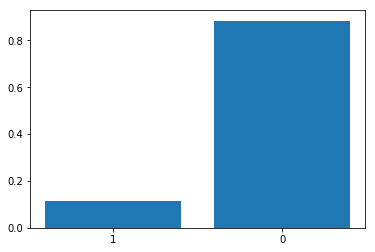

In [12]:
hist = results.histogram(key='x')

for k in hist:
    v = hist[k]
    hist[k] = v / n
    
print(hist)

plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()

Calculate the expected value. The expectation value of  $Y_{m} = -M(J)$:

In [13]:
p0 = hist[0]
p1 = hist[1]

exp_val_meas = 1 * p1 - 1 * p0

exp_val_meas

-0.7684660000000001

# Final Results
We can now compare our three results: the simulation (finite number of runs), the wavefuntion from the circuit (limit of infinite runs) and the theoretical prediction from the actual Ising Model (Hebenstreait et al.).

In [14]:
theo_val = -0.81
error_wfn = 100 * (theo_val - exp_val_wfn) / theo_val
error_meas = 100 * (theo_val - exp_val_meas) / theo_val

error_wfn, error_meas

(5.147478984872145, 5.127654320987649)

Both of our results have about 5% error, which is consistent with the results of Hebenstreait et al. for a four-qubit spin chain simulation.
